In [1]:
# 导入相关包
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import gc
from datetime import timedelta, datetime

plt.style.use('seaborn-dark') 
plt.rcParams['axes.unicode_minus']=False 
plt.rcParams['figure.figsize'] = (10.0, 5.0)
plt.rcParams['font.sans-serif'] = ['SimHei']



path = '/cos_person/data/'
train = pd.read_csv(path+'round1_iflyad_anticheat_traindata.txt', delimiter='\t')
test = pd.read_csv(path+'round1_iflyad_anticheat_testdata_feature.txt', delimiter='\t')
df = pd.concat([train.assign(is_train=1), test.assign(is_train=0)])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [280]:
# 处理时间
train["date"] = pd.to_datetime(train['nginxtime']/1000, unit='s') + timedelta(hours=8)
df["date"] = pd.to_datetime(train['nginxtime']/1000, unit='s') + timedelta(hours=8)
df['day'] = df["date"].dt.day
df['hour'] = df["date"].dt.hour
# df['minute'] = nginxdate.dt.minute

In [289]:
# 统计特征
def feature_count(data, features):
    feature_name = 'count'
    for i in features:
        feature_name += '_' + i
    temp = data.groupby(features).size().reset_index().rename(columns={0: feature_name})
    data = data.merge(temp, 'left', on=features)
    return data, feature_name
# feature_count(df, ['day','hour', 'h', 'pkgname'])[0][["label", "count_day_hour_h_pkgname"]]
# feature_count(df, ['h', 'pkgname'])[0][["label", "count_day_hour_h_pkgname"]]

In [366]:
def preprocessing(df_):
    df = df_.copy()
    
    nginxdate = pd.to_datetime(df['nginxtime']/1000, unit='s') + timedelta(hours=8)
#     df['date'] = df['nginxdate'].dt.date
    df['day'] = nginxdate.dt.day
    df['hour'] = nginxdate.dt.hour
    df['minute'] = nginxdate.dt.minute
    
    # 缺失城市填充
    df['city'] = df.groupby('province')['city'].transform(lambda x:x.fillna(method = 'ffill'))
    begin_time= df['sid'].apply(lambda x:int(x.split('-')[-1])) ##请求会话时间
    df['usetime'] = df['nginxtime'] - begin_time ##请求会话时间 与 请求到达服务时间的差
    df['usetime'] = df['usetime'] - df['usetime'].min()
    # 设备信息
    # ppi 缺失值太多 去掉该特征
    df.loc[df['w'] == -1, 'w'] = 0
    df.loc[df['h'] == -1, 'h'] = 0
    df['h_w_exception'] = 0
    df.loc[(df['h'] > 0) & (df['h'] < 240), 'h_w_exception'] = 1
    df.loc[(df['w'] > 0) & (df['w'] < 180), 'h_w_exception'] = 1
    df['w_h'] = df['w'].astype(int).astype(str) + '_' + df['h'].astype(int).astype(str)
    
    # 日期交叉统计特征
    _date_columns = ['pkgname', 'adunitshowid', 'mediashowid', 'apptype', 'ip', 'reqrealip']
    for f in _date_columns:
        df, _ = feature_count(df, ['hour', f])
    
    df, _ = feature_count(df, ['w_h'])
    df, _ = feature_count(df, ['ip', 'reqrealip'])
    df, _ = feature_count(df, ['hour', 'pkgname', 'w_h', 'model'])
    df, _ = feature_count(df, ['hour', 'mediashowid', 'w_h', 'model'])
    
    
    # 客户的统计特征
    # 分组统计f_a的f_b 数值，并作为新特征
#     f_a = ['job', 'marital', 'education']
#     f_b = ['balance', 'duration']

#     aggs = {}
#     for b in f_b:
#         aggs[b] = ['mean','max','min','std']

#     for a in f_a:
#         for b in f_b:
#             tmp = data.groupby(a, as_index=False).agg(aggs)
#             tmp.columns = [a] + get_new_columns(a, aggs)
#             data = pd.merge(data, tmp, on=a, how='left')
    
    
#     temp = df[['ip', 'day', 'hour']].groupby(['ip', 'day', 'hour'], as_index=False).size().reset_index(name='day_hour_counts')
#     temp.columns = ['ip', 'day','hour', 'day_hour_counts']
#     df= df.merge(temp, on=['ip', 'day','hour'], how='left')
    
#     df['model'].replace('PACM00', "OPPO R15", inplace=True)
#     df['model'].replace('PBAM00', "OPPO A5", inplace=True)
#     df['model'].replace('PBEM00', "OPPO R17", inplace=True)
#     df['model'].replace('PADM00', "OPPO A3", inplace=True)
#     df['model'].replace('PBBM00', "OPPO A7", inplace=True)
#     df['model'].replace('PAAM00', "OPPO R15_1", inplace=True)
#     df['model'].replace('PACT00', "OPPO R15_2", inplace=True)
#     df['model'].replace('PABT00', "OPPO A5_1", inplace=True)
#     df['model'].replace('PBCM10', "OPPO R15x", inplace=True)
    # 处理属性中出现的大小写问题
#     df['model'] = df['model'].astype('str')
#     df['model'] = df['model'].map(lambda x: x.upper())
    
    """
    df['lan'] =  df['lan'].fillna(str(-1)) # 语言
    language = ['zh-CN','Zh-CN', 'zh-cn', 'cn', 'zh_CN', 'zh', 'ZH', 'CN', 'tw','zh_CN_#Hans','zh-TW','zh-HK','zh-US','zh_HK_#Hant',
           'zh-MO','zh-','zh_TW']
    language2 = ['zh-CN','Zh-CN', 'zh-cn', 'cn', 'zh_CN', 'zh', 'ZH', 'CN', 'tw','zh_CN_#Hans','zh-TW','zh-HK','zh-US','zh_HK_#Hant',
           'zh-MO','zh-','zh_TW', '-1']
    df.loc[df['lan'].isin(language),'lan'] = 'cn'
    df.loc[~ df['lan'].isin(language2),'lan'] = 'other'
    
    proportion = df[['ip', 'label']].groupby('ip', as_index=False).mean().sort_values('label', ascending=False)
    counts = df[['ip', 'label']].groupby('ip', as_index=False).count().sort_values('label', ascending=False)
    merge = counts.merge(proportion, on='ip', how='left')
    merge.columns = ['ip', 'ip_click_count', 'ip_prop_downloaded']
    df = df.merge(merge, on='ip', how='left')
    
    
    proportion = df[['pkgname', 'label']].groupby('pkgname', as_index=False).mean().sort_values('label', ascending=False)
    counts = df[['pkgname', 'label']].groupby('pkgname', as_index=False).count().sort_values('label', ascending=False)
    merge = counts.merge(proportion, on='pkgname', how='left')
    merge.columns = ['pkgname', 'pkg_click_count', 'pkg_prop_downloaded']
    df = df.merge(merge, on='pkgname', how='left')
    
    
    proportion = df[['hour', 'label']].groupby('hour', as_index=False).mean().sort_values('label', ascending=False)
    counts = df[['hour', 'label']].groupby('hour', as_index=False).count().sort_values('label', ascending=False)
    merge = counts.merge(proportion, on='hour', how='left')
    merge.columns = ['hour', 'hour_click_count', 'hour_prop_downloaded']
    df = df.merge(merge, on='hour', how='left')
    
    
    """
    return df

df_data = preprocessing(df)

In [367]:
# 完整预处理流水线

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


# 类别属性
cat_columns = ['pkgname', 'ver', 'adunitshowid', 'apptype', 'city',
               'openudidmd5', 'idfamd5', 'macmd5', 'dvctype', 'model', 'make', 'ntt', 'carrier',
               'osv', 'orientation', 'hour', 'imeimd5', 'minute', 'day',
               'mediashowid', 'adidmd5', 'province', 'h', 'w',]

drop_cols = ['date','nginxtime', 'sid', 'is_train', 'os', 'label','w_h',  'ppi', 'ip',
             'reqrealip', 'lan']



def transform(df):
    """ 
        特征转换
    """
    labelencoder_X = LabelEncoder()
    for item in cat_columns:
        df[item] = labelencoder_X.fit_transform(df[item].astype(str))
        df[item] = df[item]
    return df

def filter_cols(_df):
    """
        删除不需要的列
    """
    df = _df.copy()
    for col in drop_cols:
        if col in df.columns:
            df.drop([col], axis=1, inplace=True)
    return df

for cat_col in df_data.columns:
    if df_data[cat_col].isnull().sum() > 0:
        df_data[cat_col].fillna(0, inplace=True)


all_train_index = (df_data['day'] <= 9).values
train_index     = (df_data['day'] <= 8).values
valid_index     = (df_data['day'] == 9).values
test_index      = (df_data['day'] == 10).values
train_label     = df_data['label']

df_uni = transform(filter_cols(df_data))

X_train= df_uni[train_index]
y_train= train_label[train_index]

X_test= df_uni[valid_index]
y_test= train_label[valid_index]

train = df_uni[all_train_index]
train_predict = train_label[all_train_index]
test = df_uni[test_index]

In [368]:
X_train.shape, X_test.shape, test.shape

((850000, 36), (150000, 36), (100000, 36))

In [369]:
X_train.head().T

,150000,150001,150002,150003,150004
adidmd5,48686.0,731103.0,588816.0,668530.0,555543.0
adunitshowid,781.0,1.0,495.0,342.0,379.0
apptype,83.0,70.0,13.0,83.0,83.0
carrier,2.0,2.0,3.0,2.0,2.0
city,114.0,70.0,29.0,317.0,231.0
dvctype,1.0,0.0,0.0,1.0,1.0
h,0.0,0.0,94.0,505.0,0.0
idfamd5,336.0,336.0,336.0,336.0,336.0
imeimd5,467082.0,1005635.0,710267.0,399138.0,484349.0
macmd5,19886.0,308687.0,308687.0,77779.0,190734.0


In [345]:
# train['count_day_hour_pkgname_w_h_model'].value_counts()
# df["model"].isnull().value_counts()


False    1095438
True        4562
Name: model, dtype: int64

In [373]:
from sklearn.feature_selection import chi2, SelectPercentile # 卡方校验
def col_filter(mtx_train, y_train, mtx_test, func=chi2, percentile=90):
    feature_select = SelectPercentile(func, percentile=percentile)
    feature_select.fit(mtx_train, y_train)
    mtx_train = feature_select.transform(mtx_train)
    mtx_test = feature_select.transform(mtx_test)
    return mtx_train, mtx_test

xxx, yyy = col_filter(
    train,
    train_predict,
    test
)
xxx.shape
# df = DataFrame(data, index=["2017-10-18", "2017-10-19", "2017-10-20", "2017-10-23"], 
#                    columns=["open", "close", "high", "low", "volume", "code"])


(1000000, 32)

In [ ]:
# 模型训练
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import KFold

# 评估函数
def lgb_f1(labels, preds):
    score = f1_score(labels, np.round(preds))
    return 'f1', score, True

n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
# clf = lgb.LGBMClassifier(
#         boosting_type="gbdt", num_leaves=30, reg_alpha=0, reg_lambda=0.,
#     max_depth=-1, n_estimators=1000, objective='binary',metric= 'auc',
#     subsample=0.8, colsample_bytree=0.8, subsample_freq=1,
#     learning_rate=0.1, random_state=42
#     )


#     params = {
#     'learning_rate': 0.01,
#     'boosting_type': 'gbdt',
#     'objective': 'binary',
#     'metric': 'auc',
#     'feature_fraction': 0.8,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'num_leaves': 1000,
#     'verbose': -1,
#     'max_depth': -1,
#     'seed':42,
#     }

clf = lgb.LGBMClassifier(random_state=2019, n_jobs=-1, objective='binary',
                     learning_rate=0.08, n_estimators=1500, num_leaves=1000, max_depth=-1,
                     min_child_samples=20, min_child_weight=9, subsample_freq=1, metric="auc",
                     subsample=0.8, colsample_bytree=0.8, reg_alpha=1, reg_lambda=5)
y_pred = 0
y_predprob = 0
for train_idx, val_idx in kfold.split(X_train):
    clf.random_state = clf.random_state + 1
    
    train_x1 = X_train.iloc[train_idx]
    train_y1 = y_train.iloc[train_idx]
    
    test_x1 = X_train.iloc[val_idx]
    test_y1 = y_train.iloc[val_idx]
    
    clf.fit(train_x1, train_y1,eval_set=[(train_x1, train_y1),(test_x1, test_y1)], eval_metric= lgb_f1,early_stopping_rounds=100,
           verbose=100,)
    y_pred += clf.predict(X_test)
    y_predprob +=clf.predict_proba(X_test)[:,1]

y_pred/=5
y_predprob/=5
print("AUC Score(Train data): %f" % roc_auc_score(y_test,y_predprob))
print("f1 Score(Train data): %f" % f1_score(y_test,np.round(y_pred)))

# 保存
clf.n_estimators = clf.best_iteration_
clf.fit(train, train_predict)
test_sid = pd.read_csv(path+'round1_iflyad_anticheat_testdata_feature.txt', delimiter='\t')['sid']
result_pd = pd.DataFrame(data=test_sid, columns=['sid'])
result_pd['label'] = clf.predict(test)
result_pd.to_csv('submit_{}.csv'.format(datetime.now().strftime('%m%d%H')), index=False)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.990736	training's f1: 0.950892	valid_1's auc: 0.983811	valid_1's f1: 0.933179
[200]	training's auc: 0.995975	training's f1: 0.967594	valid_1's auc: 0.983858	valid_1's f1: 0.933271
Early stopping, best iteration is:
[138]	training's auc: 0.993163	training's f1: 0.957667	valid_1's auc: 0.983952	valid_1's f1: 0.933408
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.990669	training's f1: 0.951137	valid_1's auc: 0.984196	valid_1's f1: 0.93421


In [311]:
train.head()

,adidmd5,adunitshowid,apptype,carrier,city,dvctype,idfamd5,imeimd5,lan,macmd5,...,w_h,count_day_hour_pkgname,count_day_hour_adunitshowid,count_day_hour_mediashowid,count_day_hour_apptype,count_day_hour_ip,count_day_hour_reqrealip,count_w_h,count_day_hour_pkgname_w_h,count_day_hour_mediashowid_w_h
0,717033,460,41,2,228,1,336,587277,24,220316,...,338,174,57,174,174,1,238,65440,39,39
1,502204,46,61,1,118,1,336,440657,19,19886,...,728,1943,125,319,347,1,83,423,8,8
2,158721,430,37,2,295,1,336,254553,24,117628,...,279,225,124,225,948,1,156,14211,19,19
3,451641,498,32,1,151,1,336,16914,19,308687,...,0,2133,64,130,400,1,28,233086,302,130
4,768430,127,70,2,194,1,336,143681,4,86480,...,307,27,25,27,823,1,18,14732,7,7


In [318]:
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

def judge_catboost(train,test,features):
    """
        利用catboost做二分类
    """
    model = CatBoostClassifier(iterations=946, depth=8,cat_features=features,learning_rate=0.05, custom_metric='F1',eval_metric='F1',random_seed=2019,
                        l2_leaf_reg=5.0,logging_level='Silent')
    model.fit(train[features],train['label'])
    y_pred = model.predict(test[features]).tolist()
    judge_df = pd.DataFrame()
    judge_df['sid'] = test['sid'].tolist()
    judge_df['label'] = y_pred
    judge_df['label'] = judge_df['label'].apply(lambda x: 1 if x>=0.5 else 0)
    return judge_df[['sid','label']]

judge_by_catboost = judge_catboost(train,test,train_predict)   
judge_by_catboost.to_csv('judge_by_catboost.csv', index=False, encoding='utf8')

AttributeError: type object '_catboost._FloatArrayWrapper' has no attribute '__reduce_cython__'

In [317]:
! pip show cython

Name: Cython
Version: 0.29.10
Summary: The Cython compiler for writing C extensions for the Python language.
Home-page: http://cython.org/
Author: Robert Bradshaw, Stefan Behnel, Dag Seljebotn, Greg Ewing, et al.
Author-email: cython-devel@python.org
License: Apache
Location: /usr/local/lib/python3.5/dist-packages
Requires: 
Required-by: 


In [266]:
def groupby_cnt_ratio(df, col):
    if isinstance(col, str):
        col = [col]
    key =  col + ['label']
    cnt_stat = df.groupby(key).size().to_frame('count')
    ratio_stat = (cnt_stat / cnt_stat.groupby(['label']).transform(pd.Series.sum)).rename(columns={'count':'count_ratio'})
    return pd.merge(cnt_stat.reset_index(), ratio_stat.reset_index(), on=key, how='outer').sort_values(by=['count'], ascending=False)

In [276]:
# xxx = groupby_cnt_ratio(train, ["h"])
# xxx
cnt_stat = train.groupby(['h','pkgname', '']).size().to_frame('count')
ratio_stat = (cnt_stat / cnt_stat.groupby(['h']).transform(pd.Series.sum)).rename(columns={'count':'count_ratio'})

xx = pd.merge(cnt_stat.reset_index(), ratio_stat.reset_index(), on=["h", 'label'], how='outer').sort_values(by=['count', 'count_ratio'], ascending=False)
xx[xx["label"] == 0]

,h,label,count,count_ratio
0,0.0,0,157912,0.736368
923,1920.0,0,98940,0.736583
625,1280.0,0,49387,0.772819
1249,2280.0,0,19230,0.374788
1268,2340.0,0,18448,0.313166
196,640.0,0,14631,0.773636
535,1080.0,0,12186,0.397728
1177,2196.0,0,11508,0.905002
1142,2160.0,0,10078,0.602283
725,1424.0,0,10035,0.968910


In [93]:
# sorted(list(df["h"].unique()))

# temp = train[['h', 'label']].groupby(['h', 'label'], as_index=False).size().reset_index(name='count')
# temp.columns = ['h', 'label','count']
# xxx = train.merge(temp, on=['h', 'label'], how='left')

Text(0.5, 1.0, 'h')

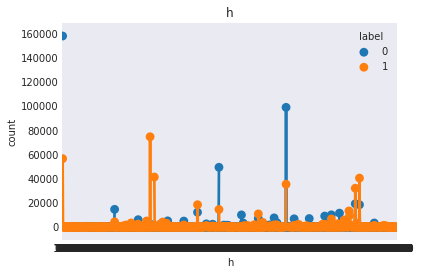

In [95]:
sns.pointplot(x='h', y='count', hue='label', data=xxx, 
            estimator=np.mean).set_title('h')

Text(0.5, 1.0, 'w')

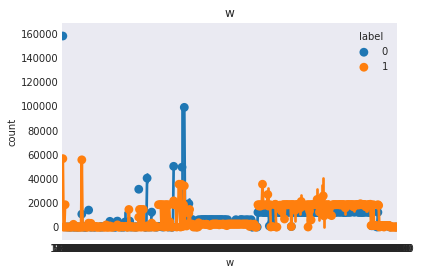

In [112]:
sns.pointplot(x='w', y='count', hue='label', data=xxx, 
            estimator=np.mean).set_title('w')

In [257]:
train[train["label"] == 0].h.value_counts()
# store_item_cnt.sort_values(by=['count'], ascending=False).head(5)

0.0       157912
1920.0     98940
1280.0     49387
2280.0     19230
2340.0     18448
640.0      14631
1080.0     12186
2196.0     11508
2160.0     10078
1424.0     10035
2136.0      9076
1800.0      7566
1520.0      7111
2070.0      7002
2016.0      6788
720.0       6075
854.0       5097
960.0       4932
1812.0      3542
2560.0      3351
1436.0      3290
2154.0      3174
1184.0      2622
760.0       2514
1208.0      2324
2214.0      2005
2030.0      1899
1776.0      1767
1344.0      1609
1356.0      1496
           ...  
1207.0         1
892.0          1
2168.0         1
2164.0         1
1174.0         1
897.0          1
1500.0         1
1209.0         1
1367.0         1
896.0          1
2907.0         1
2203.0         1
1458.0         1
3072.0         1
1193.0         1
1194.0         1
2229.0         1
1757.0         1
2224.0         1
1461.0         1
1795.0         1
1860.0         1
931.0          1
1481.0         1
2730.0         1
730.0          1
942.0          1
3040.0        

In [ ]:



store_cnt_item_cnt = store_item_cnt.groupby(['count']).size().reset_index()
store_cnt_item_cnt.columns = ['店铺商品数', '店铺数量']
plt.figure(figsize=(16,4))
sns.barplot(x='店铺商品数', y='店铺数量', data=store_cnt_item_cnt[store_cnt_item_cnt['店铺商品数']<80], estimator=np.mean)

In [ ]:
def groupby_cnt_ratio(df, col):
    if isinstance(col, str):
        col = [col]
    key =  col + ["label"]
    cnt_stat = df.groupby(key).size().to_frame('count')# .sort_values(by=['label', 'count'], ascending=False)
    return cnt_stat

In [104]:
train[(train["label"] == 0 ) & (train["h"] > 0 )].h.min()

240.0

In [103]:
train[(train["label"] == 0 ) & (train["h"] > 0 )].h.max()

6432.0

In [107]:
train[(train["label"] == 1 ) & (train["h"] > 0 )].h.max()

9024.0

In [108]:
train[(train["label"] == 0) & (train["w"] > 0 )].w.min()

180.0

In [110]:
train[(train["label"] == 1) & (train["w"] > 0 )].w.min()

50.0

In [109]:
train[(train["label"] == 0) & (train["w"] > 0 )].w.max()

8832.0

In [111]:
train[(train["label"] == 1) & (train["w"] > 0 )].w.max()

9024.0

In [155]:
train[(train["label"] == 0) & (train["ppi"] > 0 )].ppi.min()

1.0

In [127]:
sorted(list(df["h"].unique()))

[-1.0,
 0.0,
 1.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 60.0,
 100.0,
 132.0,
 140.0,
 174.0,
 200.0,
 233.0,
 239.0,
 240.0,
 277.0,
 280.0,
 282.0,
 284.0,
 285.0,
 286.0,
 292.0,
 300.0,
 320.0,
 340.0,
 344.0,
 360.0,
 369.0,
 379.0,
 382.0,
 392.0,
 393.0,
 400.0,
 408.0,
 420.0,
 426.0,
 427.0,
 432.0,
 440.0,
 441.0,
 444.0,
 446.0,
 448.0,
 450.0,
 452.0,
 454.0,
 456.0,
 458.0,
 465.0,
 466.0,
 468.0,
 470.0,
 471.0,
 472.0,
 480.0,
 483.0,
 484.0,
 485.0,
 487.0,
 492.0,
 493.0,
 494.0,
 495.0,
 496.0,
 497.0,
 498.0,
 500.0,
 503.0,
 504.0,
 505.0,
 506.0,
 512.0,
 513.0,
 517.0,
 518.0,
 519.0,
 521.0,
 522.0,
 524.0,
 525.0,
 526.0,
 527.0,
 528.0,
 529.0,
 530.0,
 531.0,
 532.0,
 533.0,
 534.0,
 536.0,
 540.0,
 550.0,
 552.0,
 554.0,
 557.0,
 558.0,
 559.0,
 560.0,
 562.0,
 564.0,
 565.0,
 566.0,
 567.0,
 568.0,
 569.0,
 570.0,
 572.0,
 576.0,
 577.0,
 582.0,
 585.0,
 587.0,
 589.0,
 591.0,
 5

In [92]:
# train.groupby(["h", "label"]).size().to_frame('count')

In [275]:
# df[df["h"] == 9024].label.value_counts()
# sorted(list(df["h"].unique()), reverse=True)
# df["w"].value_counts()
# 292.0,
#  300.0,
#  320.0,
#  340.0,
#  344.0,
#  360.0,
#  369.0,
# 456.0,
#  458.0,
#  465.0,
#  466.0,
#  468.0,
#  470.0,
#  471.0,
#  472.0,
#  480.0,
#  483.0,
#  484.0,
#  485.0,
#  487.0
device_info = ["imeimd5", "date", "adunitshowid", "mediashowid", "ip"]

train[train["h"] == 2070]
# 4ccce5bca000746198db86fd4390d1bb

,sid,label,pkgname,ver,adunitshowid,mediashowid,apptype,nginxtime,ip,city,...,ntt,carrier,os,osv,orientation,lan,h,w,ppi,date
41,3dafe1c0-0214-4678-a941-0c4773039ebf-156006318...,0,empty,7.2.0.0,af46d4c68c41ff23e606fe2b4975db25,2ab475eecfd3acf1651857c10b9d6dc6,380.0,1.560063e+12,211.145.78.135,北京市,...,2.0,46000.0,android,7.1.1,0.0,NaN,2070.0,1080.0,640.0,2019-06-09 14:53:04.509999989
78,2902ccc1-faaa-47f3-b5b9-9736e4603043-156008947...,0,0ff1fb05e89fd10fb480a9184c2c2d15,521000,580d13b46b75e6bb2f80d0e38fc3fe2c,a51cf88cec32c6cd06703838c50d19ac,318.0,1.560089e+12,106.35.211.22,锡林郭勒盟,...,2.0,46000.0,Android,7.1.1,1.0,zh-CN,2070.0,1080.0,480.0,2019-06-09 22:11:18.263000010
199,d4607dcf-8fda-445e-afad-6690e8a1b5f4-156008913...,0,0ff1fb05e89fd10fb480a9184c2c2d15,521000,be7b4818939482a91e3d20dfc2d3a19c,a51cf88cec32c6cd06703838c50d19ac,318.0,1.560089e+12,183.208.4.222,南京市,...,2.0,46000.0,Android,8.1.0,1.0,zh-CN,2070.0,1080.0,480.0,2019-06-09 22:05:35.112999916
474,09a8f820-aa28-41e8-8495-c6f801153671-156004186...,0,0ff1fb05e89fd10fb480a9184c2c2d15,521000,580d13b46b75e6bb2f80d0e38fc3fe2c,a51cf88cec32c6cd06703838c50d19ac,318.0,1.560042e+12,223.214.255.183,滁州市,...,2.0,46000.0,Android,8.1.0,1.0,zh-CN,2070.0,1080.0,480.0,2019-06-09 08:57:43.826999903
733,4d01df8e-6f68-4182-9bf5-ef0023c5d616-156006268...,0,0ff1fb05e89fd10fb480a9184c2c2d15,521000,580d13b46b75e6bb2f80d0e38fc3fe2c,a51cf88cec32c6cd06703838c50d19ac,318.0,1.560063e+12,117.136.52.229,武汉市,...,2.0,46000.0,Android,7.1.1,1.0,zh-CN,2070.0,1080.0,480.0,2019-06-09 14:44:44.184000015
837,3d6c9401-b1fc-4890-b81f-f3408b531691-156003769...,0,0ff1fb05e89fd10fb480a9184c2c2d15,521000,be7b4818939482a91e3d20dfc2d3a19c,a51cf88cec32c6cd06703838c50d19ac,318.0,1.560038e+12,123.147.250.178,重庆市,...,2.0,46000.0,Android,8.1.0,1.0,zh-CN,2070.0,1080.0,480.0,2019-06-09 07:48:18.660000086
1110,1cbe4415-72c7-4b5a-9140-8fa01aef3676-156006316...,0,0ff1fb05e89fd10fb480a9184c2c2d15,521000,be7b4818939482a91e3d20dfc2d3a19c,a51cf88cec32c6cd06703838c50d19ac,318.0,1.560063e+12,119.39.248.108,长沙市,...,2.0,46000.0,Android,8.1.0,1.0,zh-CN,2070.0,1080.0,480.0,2019-06-09 14:52:40.092999935
1275,53da7bfe-953a-451f-a2ff-f697b3778d4c-156004685...,0,0ff1fb05e89fd10fb480a9184c2c2d15,521000,be7b4818939482a91e3d20dfc2d3a19c,a51cf88cec32c6cd06703838c50d19ac,318.0,1.560047e+12,42.2.20.66,香港,...,2.0,46000.0,Android,7.1.1,1.0,zh-CN,2070.0,1080.0,480.0,2019-06-09 10:20:53.392999887
1321,ea82fcf7-e7af-4607-9a63-337bf369ae76-156003015...,0,0ff1fb05e89fd10fb480a9184c2c2d15,521000,c317c846ac9da7b89e3b1a770379e65b,a51cf88cec32c6cd06703838c50d19ac,318.0,1.560030e+12,180.138.36.51,柳州市,...,2.0,46000.0,Android,7.1.1,1.0,zh-CN,2070.0,1080.0,480.0,2019-06-09 05:42:38.085000038
1434,e03f95f3-6a75-4bc7-ab9e-561fcabe88f0-156003572...,0,0ff1fb05e89fd10fb480a9184c2c2d15,521000,580d13b46b75e6bb2f80d0e38fc3fe2c,a51cf88cec32c6cd06703838c50d19ac,318.0,1.560036e+12,112.97.63.140,深圳市,...,2.0,46000.0,Android,7.1.1,1.0,zh-CN,2070.0,1080.0,480.0,2019-06-09 07:15:28.431999922


In [253]:
# train[(train["h"] == 1480) & (train["label"] == 0) & (train["ip"] == "")].ip.value_counts()
train[(train["h"] == 1480) & (train["label"] == 1) ].ip.value_counts()

218.82.79.228      3
119.95.54.223      2
36.24.182.98       2
60.181.93.108      2
39.168.129.242     2
120.229.114.253    2
124.235.203.63     1
58.132.203.80      1
123.139.187.126    1
223.104.175.122    1
106.61.75.37       1
223.73.65.190      1
39.130.56.94       1
49.168.112.173     1
101.84.151.159     1
49.94.64.127       1
117.136.39.230     1
123.171.7.214      1
111.162.153.95     1
123.165.49.194     1
123.147.246.107    1
223.104.210.185    1
122.192.12.30      1
120.229.114.135    1
39.177.135.123     1
183.228.220.23     1
43.250.200.86      1
113.66.216.56      1
223.12.213.61      1
219.150.9.109      1
                  ..
113.118.85.188     1
106.39.149.241     1
117.136.103.139    1
115.204.30.48      1
223.104.12.227     1
60.24.88.213       1
113.218.13.42      1
117.179.190.190    1
223.74.170.228     1
171.104.207.97     1
117.136.26.217     1
36.27.65.63        1
120.193.221.40     1
14.27.55.6         1
182.51.86.67       1
117.136.30.26      1
124.160.213.1

In [274]:
# train[train["h"] == 760]
train[(train["h"] == 640) ].label.value_counts()
# train[(train["h"] == 760) & (train["label"] == 1)].ip.value_counts()

0    14631
1     4281
Name: label, dtype: int64

In [209]:
train["h"].value_counts()

0.0       214447
1920.0    134323
760.0      77156
1280.0     63905
2340.0     58908
2280.0     51309
780.0      42704
1080.0     30639
640.0      18912
1520.0     17963
2160.0     16733
2244.0     13330
2196.0     12716
1424.0     10357
2248.0      9434
2136.0      9416
1800.0      9339
720.0       8488
2016.0      8224
2070.0      7067
960.0       6669
854.0       6247
2220.0      6143
1812.0      5360
748.0       5017
2560.0      4737
830.0       4162
1184.0      3853
1560.0      3819
2030.0      3804
           ...  
4950.0         1
2845.0         1
1832.0         1
1222.0         1
1218.0         1
1207.0         1
745.0          1
521.0          1
1188.0         1
5188.0         1
528.0          1
650.0          1
1347.0         1
652.0          1
653.0          1
531.0          1
2628.0         1
661.0          1
669.0          1
2699.0         1
1340.0         1
703.0          1
1335.0         1
688.0          1
5408.0         1
174.0          1
697.0          1
1319.0        

In [288]:
# train['macmd5'].value_counts()

train[train['macmd5'] == '0f607264fc6318a92b9e13c65db7cd3c']

,sid,label,pkgname,ver,adunitshowid,mediashowid,apptype,nginxtime,ip,city,...,ntt,carrier,os,osv,orientation,lan,h,w,ppi,date
1,b660d559-db97-4b5f-9bd2-2450cb89ce77-156005074...,1,empty,NaN,10199dc8fea2e173525bc3151bd84312,3f2fc57a6e1f9c6fa4464c25cc1e88a3,319.0,1.560051e+12,106.34.14.149,开封市,...,5.0,0.0,android,Android_9,0.0,NaN,1080.0,2040.0,0.0,2019-06-09 11:25:40.122999907
18,aa6e1964-76e9-4cc6-8490-b89245efe3dd-156003788...,1,empty,5.76.2.6060,ab85ef736cd21df4861e71b73bffccab,25ad2d02765793b229e8e468a6203269,326.0,1.560038e+12,61.185.211.60,西安市,...,2.0,46001.0,android,9,0.0,zh-CN,2340.0,1080.0,0.0,2019-06-09 07:51:25.224999905
29,0633a475-ac29-4ead-a526-37913dccd4f3-156007402...,1,empty,4.3.1,430fcbd8a9106e2108713b1e415853b3,15352bbafaf25c32d5f5151250456f34,249.0,1.560074e+12,223.104.189.123,青岛市,...,6.0,46000.0,android,8.1.0,0.0,zh-cn,1520.0,720.0,2.0,2019-06-09 17:53:49.744999886
33,cdababe9-37c6-4377-b102-94b7ea3e01c6-156004495...,1,empty,5.76.2.6060,97e5b750dd758c5a2a2a5cc401c20e2a,25ad2d02765793b229e8e468a6203269,326.0,1.560045e+12,27.45.35.52,江门市,...,2.0,46000.0,android,9,0.0,zh-CN,2248.0,1080.0,0.0,2019-06-09 09:49:15.013000011
34,18649ca2-a2b0-4154-8e01-696d2dfe822a-156003998...,0,empty,5.0.1,52b5e49f63f25d1f06c4696130f15630,0c01813efdd71cd69006b50c8f493976,273.0,1.560040e+12,120.200.18.191,沈阳市,...,2.0,46000.0,android,8.1.0,0.0,NaN,2340.0,1080.0,0.0,2019-06-09 08:26:27.497999907
38,f4b3c66b-5168-4d13-814f-6ade74accf04-156004240...,1,empty,5.76.2.6060,a03caee254dc4d2c20af52f46ae6fbb9,25ad2d02765793b229e8e468a6203269,326.0,1.560042e+12,123.191.51.194,沈阳市,...,2.0,46000.0,android,9,0.0,zh-CN,2340.0,1080.0,0.0,2019-06-09 09:06:47.803999901
83,d48abbdf-6582-4c71-9f54-6a5dc96b2f41-156003493...,0,b47e3517e716b8aa9f11beccea486bb3,6.0.5.1,d148caa10b76d5d12eeb8f2f5fd1c88d,f9a6552931c92bfacf81ac70b67097b7,273.0,1.560035e+12,115.198.54.90,杭州市,...,2.0,46000.0,Android,8.1.0,0.0,zh-CN,1080.0,2280.0,480.0,2019-06-09 07:02:17.496000051
84,e3f4d705-e0ef-434b-87b4-3bf375926f6e-156001012...,1,empty,5.76.2.6060,b3c87241f8806ee2f9feba881d03d42c,25ad2d02765793b229e8e468a6203269,326.0,1.560010e+12,183.224.14.4,昆明市,...,2.0,46000.0,android,9,0.0,zh-CN,2280.0,1080.0,0.0,2019-06-09 00:08:44.667999983
86,c3d6c033-0dc1-464d-a8e6-8a4de2fbb376-156001306...,1,empty,5.76.2.6060,c44de6c45e712be3cdcaa63e92077b62,25ad2d02765793b229e8e468a6203269,326.0,1.560013e+12,113.250.253.121,重庆市,...,2.0,46000.0,android,9,0.0,zh-CN,2280.0,1080.0,0.0,2019-06-09 00:57:45.352999926
94,ad165665-2ee5-4171-a007-44e1c4a7d83d-156005779...,0,empty,5.76.2.6060,7fc0dbaa3f8115d147828a288c6bb335,25ad2d02765793b229e8e468a6203269,326.0,1.560058e+12,106.114.245.234,石家庄市,...,2.0,46003.0,android,8.1.0,0.0,zh-CN,2340.0,1080.0,0.0,2019-06-09 13:23:14.223999977
